In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from matplotlib import rc
from matplotlib import font_manager
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from lightgbm import LGBMClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras import preprocessing
from tensorflow.keras.utils import to_categorical
path='c:/Windows/Fonts/malgun.ttf'
font_name=font_manager.FontProperties(fname=path).get_name()
rc("font",family=font_name)

IT과학,0
경제,1
사회,2
생활문화,3
세계,4
스포츠,5
정치,6

In [2]:
train=pd.read_csv('train_data.csv')
test=pd.read_csv('test_data.csv')

In [3]:
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


## EDA

In [4]:
#전처리
def clean_text(sent):
    sent_clean=re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s0-9A-Za-z]", " ", sent)
    return sent_clean

In [5]:
train["cleaned_title"] = train["title"].apply(lambda x : clean_text(x))
test["cleaned_title"]  = test["title"].apply(lambda x : clean_text(x))

In [6]:
train.tail()

,index,title,topic_idx,cleaned_title
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1,KB금융 미국 IB 스티펠과 제휴 선진국 시장 공략
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,1보 서울시교육청 신종코로나 확산에 개학 연기 휴업 검토
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1,게시판 키움증권 2020 키움 영웅전 실전투자대회
45652,45652,답변하는 배기동 국립중앙박물관장,2,답변하는 배기동 국립중앙박물관장
45653,45653,2020 한국인터넷기자상 시상식 내달 1일 개최…특별상 김성후,2,2020 한국인터넷기자상 시상식 내달 1일 개최 특별상 김성후


In [7]:
train_text = train["cleaned_title"].tolist()
test_text = test["cleaned_title"].tolist()

In [8]:
len(test_text)

9131

<AxesSubplot:>

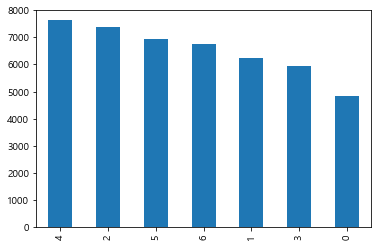

In [9]:
train['topic_idx'].value_counts().plot(kind='bar') #세계면이 제일 많음을 확인.

In [24]:
okt=Okt()

In [12]:
for i in train_text[:5]: #명사 추출
    print(okt.nouns(i))

['인천', '핀란드', '항공기', '결항', '휴가', '철', '여행객', '분통']
['실리콘밸리', '구글', '전역', '거점']
['이란', '외무', '긴장', '완화', '해결', '책', '미국', '경제', '전쟁', '것']
['클린턴', '측근', '기업', '특수', '관계', '조명', '공과', '사', '종합']
['시진핑', '트럼프', '중미', '무역', '협상', '조속', '타결', '희망']


In [13]:
#문장 단어 분포도
vocab={}
for sent in train_text:
    for word in okt.morphs(sent):
        if word not in vocab.keys():
            vocab[word]=len(vocab)

In [14]:
print(len(vocab))

35012


In [15]:
text_len=[len(okt.morphs(s)) for s in train_text]
print('가장 적은 단어 수 : {}'.format(np.min(text_len)))
print('가장 많은 단어 수 : {}'.format(np.max(text_len)))
print('평균 문장 단어 : {}'.format(np.mean(text_len)))

가장 적은 단어 수 : 1
가장 많은 단어 수 : 20
평균 문장 단어 : 10.19249134796513


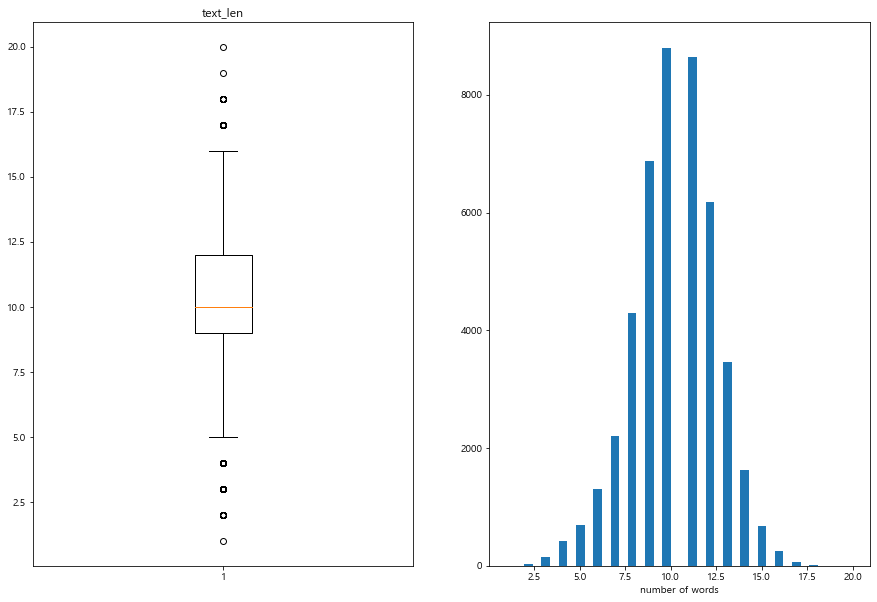

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text_len')
#text 길이는 중위수가 10, 평균이 8에 가깝다.
plt.subplot(1,2,2)
plt.hist(text_len,bins=40)
plt.xlabel('number of words')
plt.show()
#단어의 수는 10에서 많은 편이다.

In [17]:
#문장길이
str_len=[len(s) for s in train_text]
print('가장 적은 문장 : {}'.format(np.min(str_len)))
print('가장 긴 문장  : {}'.format(np.max(str_len)))
print('평균 문장 문장 : {}'.format(np.mean(str_len)))

가장 적은 문장 : 4
가장 긴 문장  : 44
평균 문장 문장 : 27.330551539843167


## 분야마다 많이 사용한 단어 분포

In [18]:
def plot_wordcloud(text):#워드클라우딩(명사 추출)
    def preprocess_text(text):
        corpus=[]
        for a in text:
            tokens = [word for word in okt.nouns(a)]
            corpus.extend(tokens)
        return corpus
    corpus=preprocess_text(text)
    count = Counter(corpus)
    words = dict(count.most_common())
    wordcloud = WordCloud(
    font_path='malgun',
    background_color='white',
    max_words=100,
    max_font_size=50, 
    scale=7,
    random_state=1)
    wordcloud = wordcloud.generate_from_frequencies(words)
    return wordcloud

IT과학,0 경제,1 사회,2 생활문화,3 세계,4 스포츠,5 정치,6

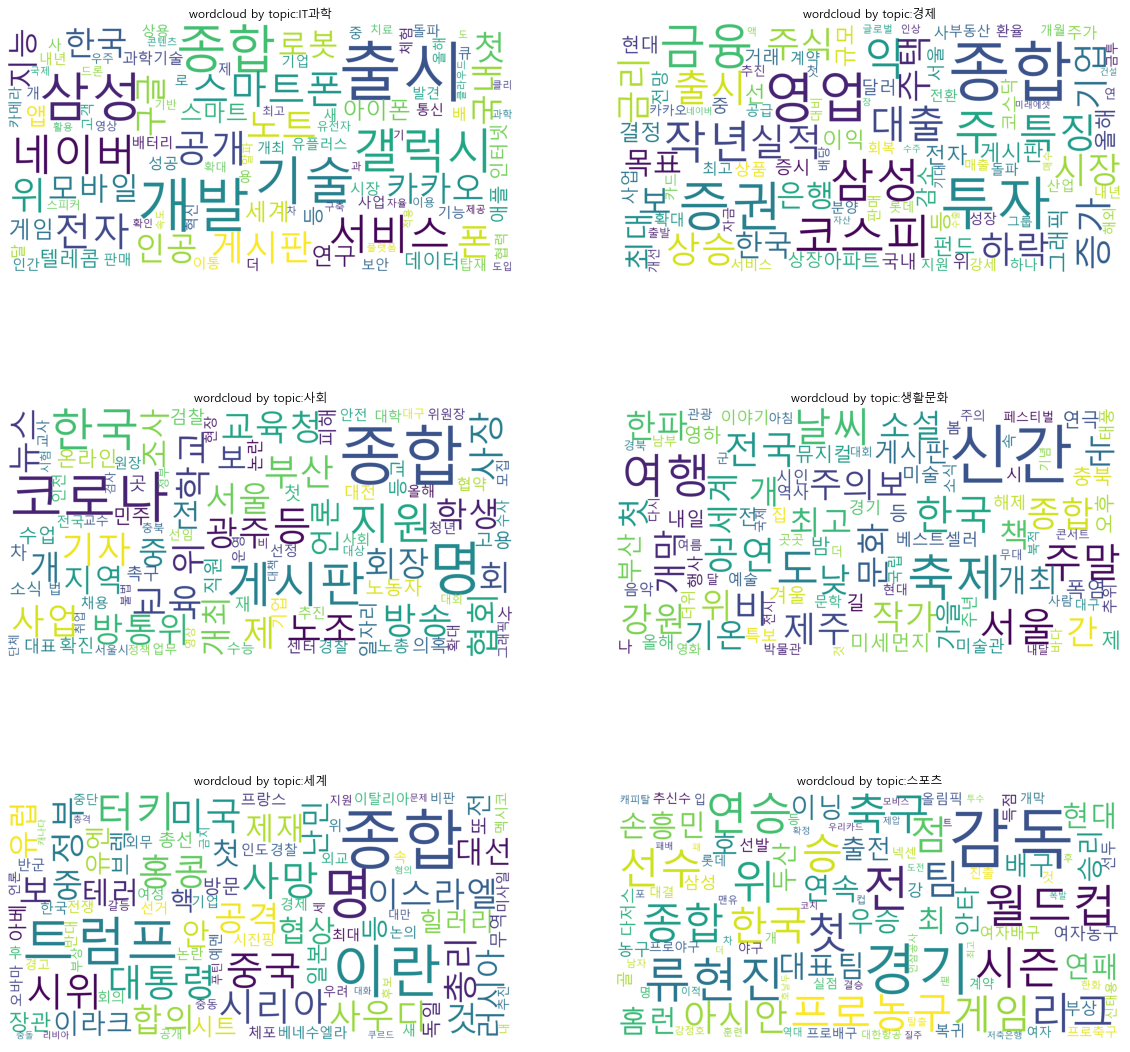

In [19]:
fig=plt.figure(figsize=(20,20))
rows=3
cols=2
topic=['IT과학','경제','사회','생활문화','세계','스포츠','정치']
for i in range(6):
    wordcloud=plot_wordcloud(train[train['topic_idx']==i]['cleaned_title'])
    ax=fig.add_subplot(rows,cols,i+1)
    ax.axis('off')
    ax.set_title('wordcloud by topic:{}'.format(topic[i]))
    ax.imshow(wordcloud)

In [20]:
# f = open("./koreanStopwords.txt", 'r',encoding='UTF-8')
# lines = f.readlines()
# stopwords = []
# for line in lines:
#     line = line.replace('\n', '')
#     stopwords.append(line)
# f.close()

In [21]:
def plot_wordcloud_words(text):#워드클라우딩(단어 추출, 불용어 제거)
    def preprocess_text(text):
        corpus=[]
        for a in text:
            tokens = [word[0] for word in okt.pos(a) if word[1] not in ['Josa','Determiner',
                                        'Eomi','Exclamation','KoreanParticle']]
            corpus.extend(tokens)
        return corpus
    corpus=preprocess_text(text)
    count = Counter(corpus)
    words = dict(count.most_common())
    wordcloud = WordCloud(
    font_path='malgun',
    background_color='white',
    max_words=100,
    max_font_size=50, 
    scale=7,
    random_state=1)
    wordcloud = wordcloud.generate_from_frequencies(words)
    return wordcloud

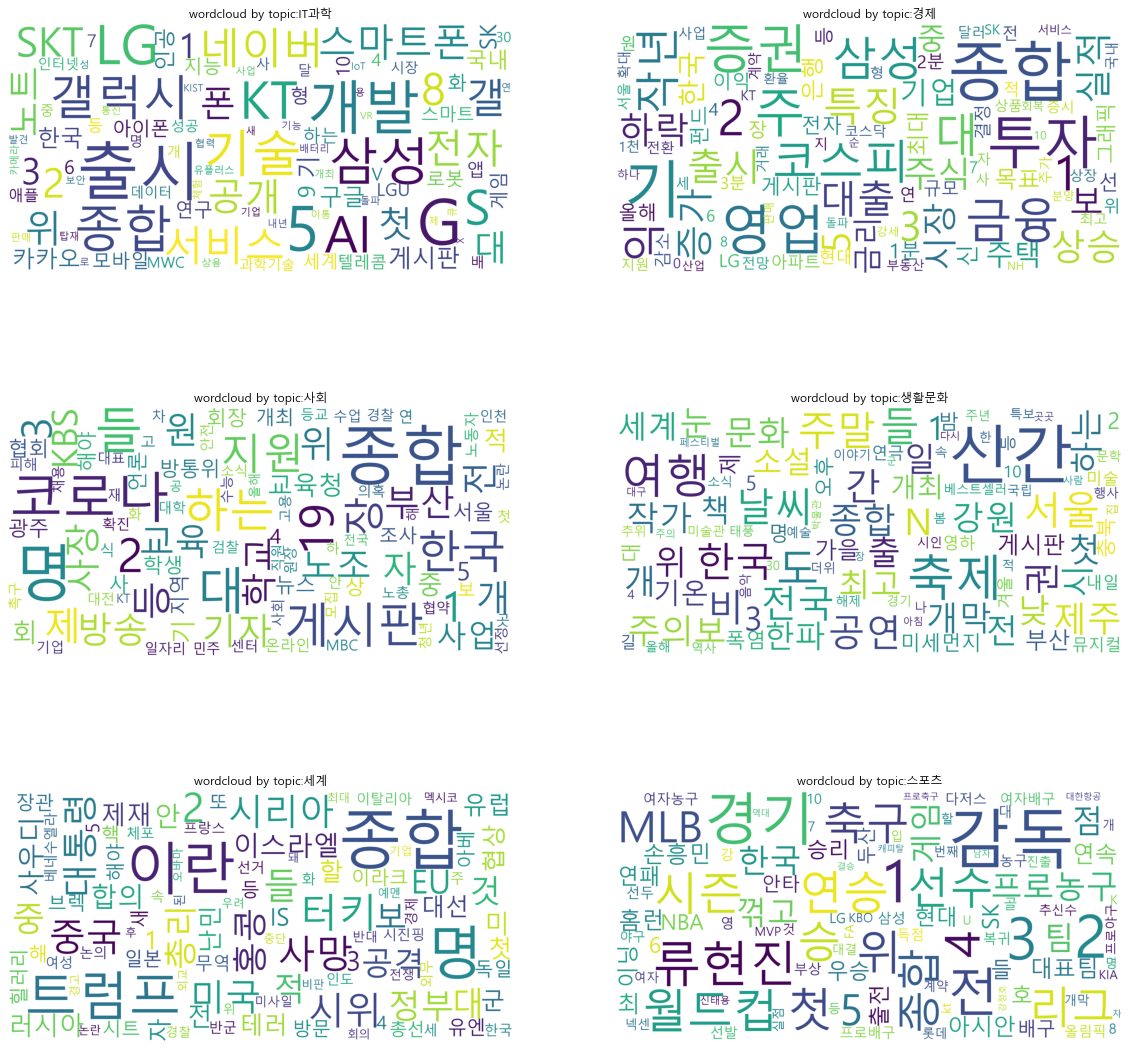

In [22]:
fig=plt.figure(figsize=(20,20))
rows=3
cols=2
topic=['IT과학','경제','사회','생활문화','세계','스포츠','정치']
for i in range(6):
    wordcloud=plot_wordcloud_words(train[train['topic_idx']==i]['cleaned_title'])
    ax=fig.add_subplot(rows,cols,i+1)
    ax.axis('off')
    ax.set_title('wordcloud by topic:{}'.format(topic[i]))
    ax.imshow(wordcloud)

In [23]:
#동사 추출
def plot_wordcloud_verbs(text):#워드클라우딩(단어 추출, 불용어 제거)
    def preprocess_text(text):
        corpus=[]
        for a in text:
            tokens = [word[0] for word in okt.pos(a) if word[1] in ['Verb']]
            corpus.extend(tokens)
        return corpus
    corpus=preprocess_text(text)
    count = Counter(corpus)
    words = dict(count.most_common())
    wordcloud = WordCloud(
    font_path='malgun',
    background_color='white',
    max_words=100,
    max_font_size=50, 
    scale=7,
    random_state=1)
    wordcloud = wordcloud.generate_from_frequencies(words)
    return wordcloud

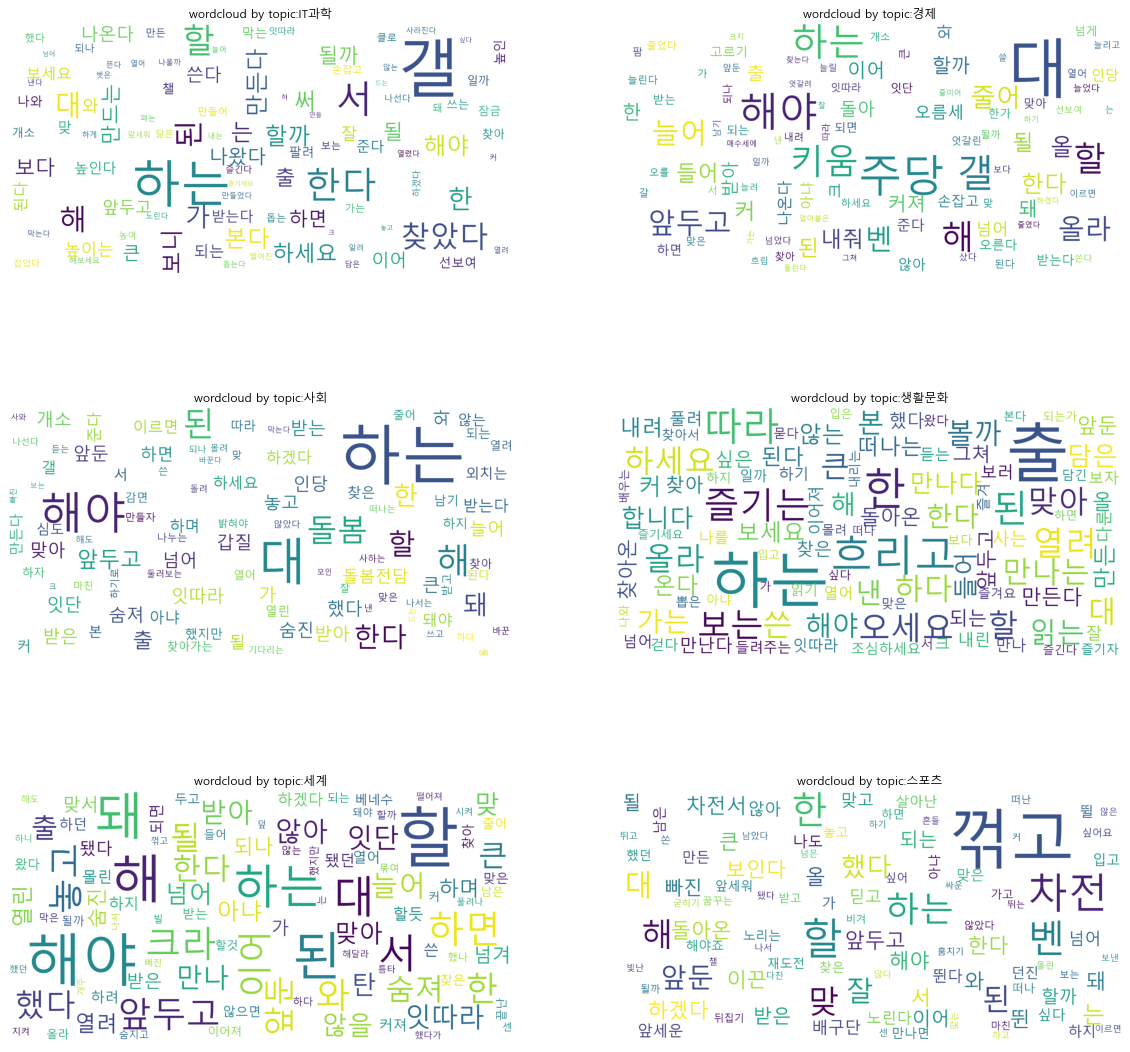

In [24]:
fig=plt.figure(figsize=(20,20))
rows=3
cols=2
topic=['IT과학','경제','사회','생활문화','세계','스포츠','정치']
for i in range(6):
    wordcloud=plot_wordcloud_verbs(train[train['topic_idx']==i]['cleaned_title'])
    ax=fig.add_subplot(rows,cols,i+1)
    ax.axis('off')
    ax.set_title('wordcloud by topic:{}'.format(topic[i]))
    ax.imshow(wordcloud)

In [25]:
train_text[:10]

['인천 핀란드 항공기 결항 휴가철 여행객 분통',
 '실리콘밸리 넘어서겠다 구글 15조원 들여  전역 거점화',
 '이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것',
 'NYT 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합',
 '시진핑 트럼프에 중미 무역협상 조속 타결 희망',
 '팔레스타인 가자지구서 16세 소년 이스라엘군 총격에 사망',
 '인도 48년 만에 파키스탄 공습 테러 캠프 폭격종합2보',
 ' 대선 TV토론 음담패설 만회실패 트럼프 사과 대신 빌클린턴 공격해 역효과',
 '푸틴 한반도 상황 진전 위한 방안 김정은 위원장과 논의',
 '특검 면죄부 받은 트럼프 스캔들 보도 언론 맹공 국민의 적']

In [66]:
train.head(10)

,index,title,topic_idx,cleaned_title
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천 핀란드 항공기 결항 휴가철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망
5,5,팔레스타인 가자지구서 16세 소년 이스라엘군 총격에 사망,4,팔레스타인 가자지구서 세 소년 이스라엘군 총격에 사망
6,6,인도 48년 만에 파키스탄 공습…테러 캠프 폭격종합2보,4,인도 년 만에 파키스탄 공습 테러 캠프 폭격종합 보
7,7,美대선 TV토론 음담패설 만회실패 트럼프…사과 대신 빌클린턴 공격해 역효과,4,대선 토론 음담패설 만회실패 트럼프 사과 대신 빌클린턴 공격해 역효과
8,8,푸틴 한반도 상황 진전 위한 방안 김정은 위원장과 논의,4,푸틴 한반도 상황 진전 위한 방안 김정은 위원장과 논의
9,9,특검 면죄부 받은 트럼프 스캔들 보도 언론 맹공…국민의 적,4,특검 면죄부 받은 트럼프 스캔들 보도 언론 맹공 국민의 적


In [59]:
corpus=[word for word in okt.morphs(i) for i in train_text]

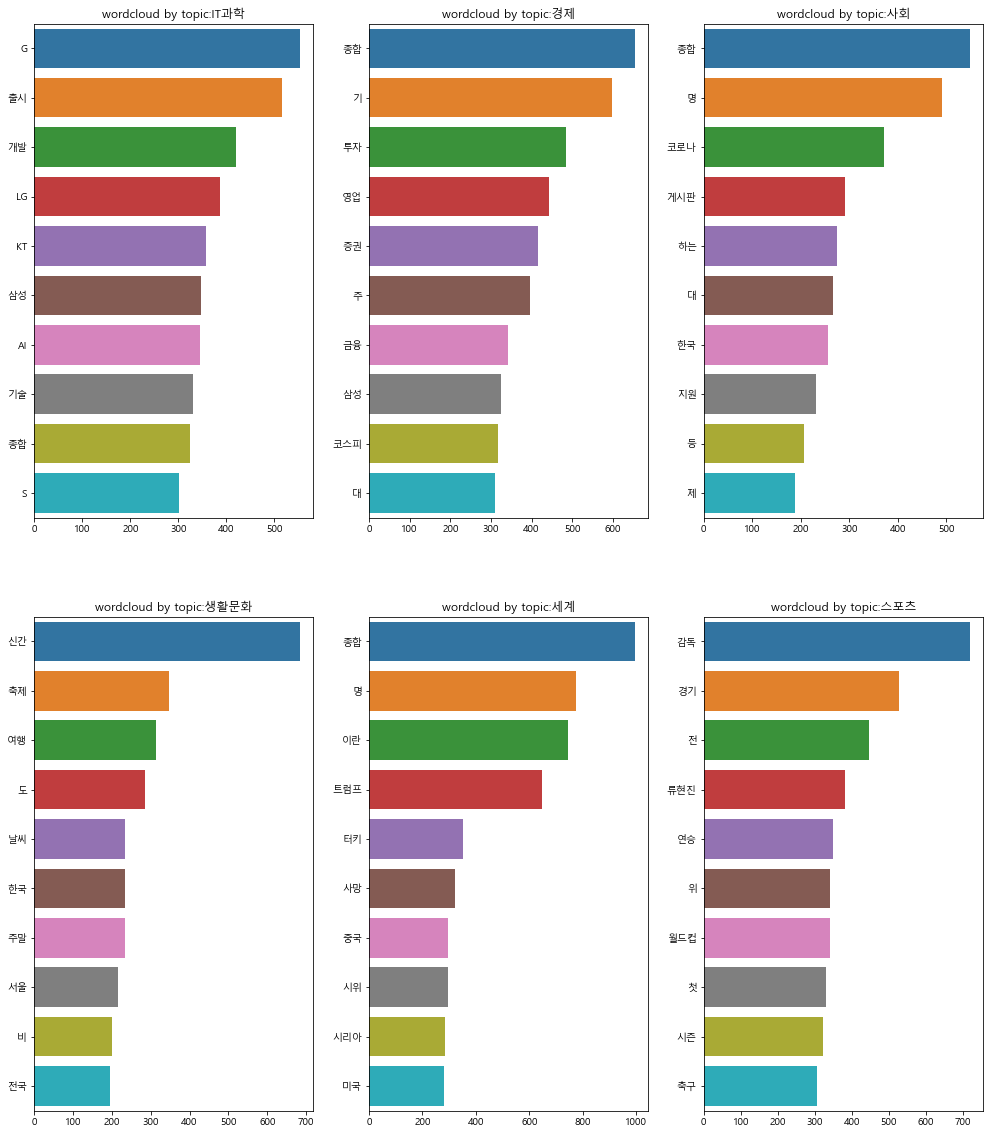

In [70]:
fig=plt.figure(figsize=(17,20)) #전처리 한 상태에서 제일 많이 나온 단어
rows=2
cols=3
topic=['IT과학','경제','사회','생활문화','세계','스포츠','정치']
def plot_top_non_stopwords_barchart(text):
    corpus=[]
    for i in text:
        for word in okt.pos(i):
            if word[1] not in ['Josa','Determiner','Eomi','Exclamation','KoreanParticle','Number','Suffix']:
                corpus.append(word[0])
    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:10]:
        x.append(word)
        y.append(count)
    return x, y
for i in range(6):
    x,y = plot_top_non_stopwords_barchart(train[train['topic_idx']==i]['cleaned_title'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title('wordcloud by topic:{}'.format(topic[i]))
    sns.barplot(x=y,y=x)

## 모델 설계(딥러닝-TfidfVectorizer)

In [162]:
train_label = np.asarray(train.topic_idx)

tfidf = TfidfVectorizer(analyzer='word', sublinear_tf=True, ngram_range=(1, 2), max_features=150000, binary=False)

tfidf.fit(train_text)

train_tf_text = tfidf.transform(train_text).astype('float32')
test_tf_text  = tfidf.transform(test_text).astype('float32')

In [169]:
model=Sequential()
model.add(Dense(128,input_dim=150000,activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(7,activation='softmax'))

In [170]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',
             metrics=['accuracy'])

In [171]:
history = model.fit(x = train_tf_text[:40000], y = train_label[:40000],
                    validation_data =(train_tf_text[40000:], train_label[40000:]),
                    epochs = 10)

Epoch 1/10
1250/1250 [==============================] - 235s 187ms/step - loss: 1.4433 - accuracy: 0.5303 - val_loss: 1.1150 - val_accuracy: 0.7276
Epoch 2/10
1250/1250 [==============================] - 236s 189ms/step - loss: 0.7032 - accuracy: 0.7978 - val_loss: 0.7710 - val_accuracy: 0.7731
Epoch 3/10
1250/1250 [==============================] - 239s 191ms/step - loss: 0.4566 - accuracy: 0.8680 - val_loss: 0.6615 - val_accuracy: 0.7878
Epoch 4/10
1250/1250 [==============================] - 238s 190ms/step - loss: 0.3289 - accuracy: 0.9070 - val_loss: 0.6224 - val_accuracy: 0.7911
Epoch 5/10
1250/1250 [==============================] - 238s 190ms/step - loss: 0.2511 - accuracy: 0.9300 - val_loss: 0.6130 - val_accuracy: 0.7927
Epoch 6/10
1250/1250 [==============================] - 237s 190ms/step - loss: 0.1958 - accuracy: 0.9446 - val_loss: 0.6173 - val_accuracy: 0.7952
Epoch 7/10
1250/1250 [==============================] - 237s 190ms/step - loss: 0.1590 - accuracy: 0.9553 - val_

In [156]:
tmp_pred

array([[1.8392096e-01, 1.6549023e-02, 5.5856925e-02, ..., 2.5577333e-03,
        2.4906936e-04, 2.3520511e-04],
       [1.0477267e-07, 3.4472805e-07, 7.3279753e-06, ..., 3.9662195e-06,
        2.5656911e-07, 1.7984344e-07],
       [2.8021982e-02, 3.5701789e-02, 6.8879771e-01, ..., 3.4953546e-02,
        1.8154824e-02, 1.9342576e-01],
       ...,
       [1.3283428e-02, 1.4856813e-04, 2.4597290e-01, ..., 7.0828056e-01,
        4.1765205e-05, 2.8416604e-05],
       [7.5309724e-03, 3.5028622e-04, 9.7919512e-01, ..., 5.2911817e-04,
        1.5644903e-03, 6.0172556e-03],
       [3.9966832e-04, 1.2529093e-04, 9.9764508e-01, ..., 2.9808372e-05,
        2.8517661e-05, 1.7426413e-03]], dtype=float32)

In [92]:
tmp_pred=model.predict(test_tf_text)
pred=np.argmax(tmp_pred,axis=1)

286/286 [==============================] - 2s 882us/step


In [93]:
pred

array([3, 3, 2, ..., 4, 2, 2], dtype=int64)

## Tfidf 사용x

In [19]:
train.head()

,index,title,topic_idx,cleaned_title
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천 핀란드 항공기 결항 휴가철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,실리콘밸리 넘어서겠다 구글 15조원 들여 전역 거점화
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,NYT 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망


In [99]:
X_train=[]
for sentence in train['cleaned_title']:
    tokenized_sentence=okt.pos(sentence)
    stopwords_removed_sentence = [word[0] for word in tokenized_sentence if  word[1] not in ['Josa','Determiner','Eomi','Exclamation','KoreanParticle','Number','Suffix']]
    X_train.append(stopwords_removed_sentence)

In [100]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [101]:
print(tokenizer.word_index)

{'종합': 1, '명': 2, '대통령': 3, '한국': 4, '전': 5, '위': 6, '대': 7, '기': 8, '하는': 9, '첫': 10, '삼성': 11, '등': 12, '보': 13, '이란': 14, '감독': 15, '출시': 16, '경기': 17, 'g': 18, '주': 19, '게시판': 20, 'lg': 21, '트럼프': 22, '신간': 23, '것': 24, '제': 25, 'kt': 26, '문': 27, '안': 28, '개': 29, '중': 30, '정부': 31, '투자': 32, '개발': 33, '서울': 34, '지원': 35, 'sk': 36, '더': 37, '해야': 38, '할': 39, '최고': 40, '중국': 41, '올해': 42, '해': 43, '민주': 44, '차': 45, '개최': 46, '사': 47, '영업': 48, '회': 49, '세계': 50, '새': 51, '현대': 52, '연': 53, '비': 54, '미국': 55, '공개': 56, '도': 57, '일': 58, '최': 59, '기업': 60, '기술': 61, '증권': 62, '코로나': 63, '작년': 64, '신': 65, '대표': 66, '금융': 67, '시장': 68, '게임': 69, '최대': 70, '수': 71, '한': 72, '김정은': 73, '총리': 74, '속': 75, '선': 76, '시': 77, 's': 78, '북한': 79, '서비스': 80, '간': 81, '사망': 82, '전자': 83, '축제': 84, '국내': 85, '달': 86, '세': 87, '사업': 88, '류현진': 89, '후': 90, '터키': 91, '점': 92, '전국': 93, '합의': 94, '그래픽': 95, 'ai': 96, '여행': 97, '추진': 98, '월드컵': 99, '팀': 100, '당': 101, '대회': 102, '네이버': 103, '장관': 

In [102]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32507
등장 빈도가 2번 이하인 희귀 단어의 수: 18047
단어 집합에서 희귀 단어의 비율: 55.5172732026948
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.822492227131402


In [103]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 14461


In [104]:
X_test=[]
for sentence in test['cleaned_title']:
    tokenized_sentence=okt.pos(sentence)
    stopwords_removed_sentence = [word[0] for word in tokenized_sentence if  word[1] not in ['Josa','Determiner','Eomi','Exclamation','KoreanParticle','Number','Suffix']]
    X_test.append(stopwords_removed_sentence)

In [105]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [106]:
drop_train=[index for index,sentence in enumerate(X_train) if len(sentence)<1]

In [107]:
print(len(drop_train))

2


In [109]:
X_train

[[335, 4968, 2519, 5299, 1088, 1204, 2741, 8873],
 [5661, 324, 7185, 1566, 3247],
 [14, 674, 909, 803, 621, 378, 55, 134, 413, 24],
 [3807, 2667, 3117, 60, 1537, 804, 1272, 11885, 47, 721, 10127, 1],
 [568, 22, 4665, 450, 168, 4414, 2372, 793],
 [1965, 2520, 87, 1538, 4666, 1000, 82],
 [466, 1914, 1167, 271, 1453, 2668, 1, 13],
 [268, 294, 1677, 7946, 8874, 782, 22, 942, 551, 4969, 2667, 162, 43],
 [860, 552, 726, 2373, 6, 805, 73, 159, 150],
 [846, 7947, 1168, 22, 3370, 448, 187, 4415, 155, 1785],
 [3977, 1874, 1915, 3248, 486, 7186],
 [14, 40, 960, 5662, 442, 2742, 1916, 2135],
 [8875, 84, 3808, 4667, 750, 4416, 1205, 4970, 3371],
 [3372, 932, 1389, 1875, 271, 174, 761, 54, 28, 1917],
 [1832, 42, 703, 1370, 451],
 [1876, 985, 7948, 622, 129],
 [263, 1180, 4417, 188, 1638, 168, 3016],
 [1371, 274, 693, 1454, 4195, 733, 414],
 [274, 5663, 1058, 162, 891, 711, 771, 14, 1089],
 [415, 5664, 7949, 5665, 2669, 892],
 [222, 501, 493, 94, 5, 38, 39, 58, 1678, 525],
 [1108, 152, 5666, 918, 132

In [110]:
y_train = np.array(train['topic_idx'])
y_train=np.delete(y_train,drop_train,axis=0)

In [111]:
X_train=np.delete(X_train,drop_train,axis=0)

C:\Users\aaa\anaconda3\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [113]:
print(len(X_train),len(y_train))

45652 45652


리뷰의 최대 길이 : 16
리뷰의 평균 길이 : 8.06790204582293


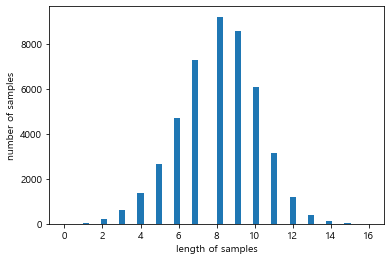

In [108]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [114]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [115]:
max_len = 10
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 10 이하인 샘플의 비율: 89.33453079821257


In [116]:
X_train[0]

[335, 4968, 2519, 5299, 1088, 1204, 2741, 8873]

In [117]:
y_train[0]

4

In [118]:
x_tr,x_ts,y_tr,y_ts=train_test_split(X_train,y_train,test_size=0.3)

In [121]:
x_tr = pad_sequences(x_tr, maxlen=max_len)
x_ts = pad_sequences(x_ts, maxlen=max_len)

y_tr = to_categorical(y_tr)
y_ts = to_categorical(y_ts)

In [122]:
x_tr

array([[    0,     0,     0, ...,  8623,   318,   769],
       [    0,     0,    31, ...,   676,   261,    38],
       [    0,     0,     0, ...,   500,   514,  4986],
       ...,
       [    0,     0,     0, ...,   329,   384,  5672],
       [  739,    34,   335, ...,   131,   368,    13],
       [   25,   469, 11258, ...,  1623,  4654,    30]])

In [128]:
y_tr

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [127]:
print(y_tr[0])

[0. 0. 1. 0. 0. 0. 0.]


In [133]:
test.head()

,index,title,cleaned_title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사,어버이날 맑다가 흐려져 남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


In [132]:
embedding_dim = 100
hidden_units = 128
vocab_size=15000
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(LSTM(hidden_units))
model.add(Dense(7, activation='softmax'))

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('LSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(loss='categorical_crossentropy',optimizer='adam',
             metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='c', metrics=['acc'])
history = model.fit(x_tr, y_tr, epochs=10, batch_size=64,validation_data=(x_ts,y_ts))

Epoch 1/10
500/500 [==============================] - 14s 23ms/step - loss: 0.8313 - accuracy: 0.7056 - val_loss: 0.5475 - val_accuracy: 0.8161
Epoch 2/10
500/500 [==============================] - 11s 22ms/step - loss: 0.3460 - accuracy: 0.8854 - val_loss: 0.5525 - val_accuracy: 0.8156
Epoch 3/10
500/500 [==============================] - 11s 21ms/step - loss: 0.2117 - accuracy: 0.9315 - val_loss: 0.6188 - val_accuracy: 0.8061
Epoch 4/10
500/500 [==============================] - 11s 22ms/step - loss: 0.1462 - accuracy: 0.9519 - val_loss: 0.7446 - val_accuracy: 0.7976
Epoch 5/10
500/500 [==============================] - 11s 22ms/step - loss: 0.1056 - accuracy: 0.9647 - val_loss: 0.9030 - val_accuracy: 0.7856
Epoch 6/10
500/500 [==============================] - 11s 22ms/step - loss: 0.0793 - accuracy: 0.9737 - val_loss: 0.9770 - val_accuracy: 0.7884
Epoch 7/10
500/500 [==============================] - 11s 22ms/step - loss: 0.0635 - accuracy: 0.9793 - val_loss: 1.0792 - val_accuracy:

In [135]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(x_ts,y_ts)[1]))

428/428 [==============================] - 2s 3ms/step - loss: 1.4082 - accuracy: 0.7777

 테스트 정확도: 0.7777


In [154]:
x_ts

array([[ 8076,   423,   135, ...,   481,  2980,  8535],
       [    0,     0,     0, ...,     5,   240,   961],
       [    0,     0,     0, ...,  2982,   452,  1264],
       ...,
       [    0,  1063,   239, ..., 10621,  5191,  1177],
       [    0,     0,     0, ...,  2110, 13458,    36],
       [ 7218,   849,   208, ...,   439,   288,   920]])

In [158]:
y_real=np.argmax(y_ts,axis=1)
print(y_real)

[5 5 2 ... 3 5 5]


In [159]:
y_pred=model.predict(x_ts)

428/428 [==============================] - 1s 3ms/step


In [160]:
y_pred=np.argmax(y_pred,axis=1)

In [161]:
np.mean(y_pred==y_real) #정확도 0.78%

0.7777453271028038

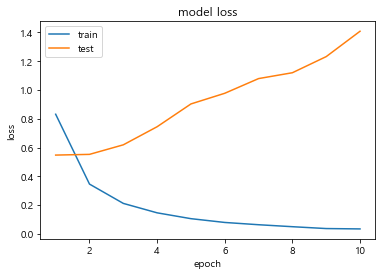

In [137]:
epochs = range(1, len(history.history['accuracy']) + 1) #Dense,Dropout사용
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [140]:
X_test = pad_sequences(X_test, maxlen=max_len)

In [145]:
pred=model.predict(X_test)

286/286 [==============================] - 1s 3ms/step


In [146]:
pred=np.argmax(pred,axis=1)

In [147]:
pred

array([2, 3, 6, ..., 2, 2, 6], dtype=int64)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [150]:
submission = pd.read_csv("sample_submission.csv")

In [151]:
submission.topic_idx = pred

In [152]:
submission.head()

,index,topic_idx
0,45654,2
1,45655,3
2,45656,6
3,45657,0
4,45658,3


In [153]:
submission['topic_idx'].value_counts()

4    1464
6    1394
5    1389
2    1320
3    1276
1    1248
0    1040
Name: topic_idx, dtype: int64

In [99]:
submission.to_csv('dlp.csv', index = False)

In [100]:
train_tf_text

<45654x150000 sparse matrix of type '<class 'numpy.float32'>'
	with 406661 stored elements in Compressed Sparse Row format>

In [101]:
hist_df=pd.DataFrame(history.history)

In [103]:
hist_df

,loss,accuracy,val_loss,val_accuracy
0,1.405584,0.543300,1.104857,0.731694
1,0.676366,0.804950,0.762926,0.775203
2,0.432975,0.876900,0.656728,0.785992
3,0.309109,0.911800,0.631294,0.789706
4,0.233619,0.934900,0.622057,0.791475
5,0.184178,0.949825,0.627478,0.792359
6,0.146062,0.959250,0.637763,0.790414
7,0.124570,0.965450,0.646846,0.793421
8,0.105157,0.971100,0.667712,0.788999
9,0.086194,0.975650,0.678506,0.789706


In [102]:
y_vloss=hist_df['val_loss']
y_loss=hist_df['loss']

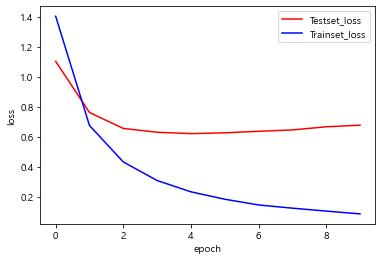

In [104]:
x_len=np.arange(len(y_loss)) #
plt.plot(x_len,y_vloss,'-',c='red',markersize=2,label='Testset_loss')
plt.plot(x_len,y_loss,'-',c='blue',markersize=2,label='Trainset_loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 머신러닝

In [106]:
def split(text):
    tokens=okt.morphs(text)
    return tokens

In [108]:
train.head()

,index,title,topic_idx,cleaned_title
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천 핀란드 항공기 결항 휴가철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,실리콘밸리 넘어서겠다 구글 15조원 들여 전역 거점화
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,NYT 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망


In [110]:
tfidf_vect = TfidfVectorizer(tokenizer=split)
tfidf_vect.fit(train['cleaned_title'])
tfidf_matrix_train = tfidf_vect.transform(train['cleaned_title'])

In [111]:
X_train,X_test,y_train,y_test=train_test_split(tfidf_matrix_train,train['topic_idx'])

In [115]:
lgbm = LGBMClassifier(random_state = 42)
lgbm.fit(X_train,y_train)

LGBMClassifier(random_state=42)

In [116]:
pred = lgbm.predict(X_test)
accuracy = accuracy_score(y_test,pred)

print('정확도', accuracy)

정확도 0.7966532328719117


In [117]:
test.head()

,index,title,cleaned_title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사,어버이날 맑다가 흐려져 남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


In [118]:
tfidf_matrix_test = tfidf_vect.transform(test['cleaned_title'])

In [119]:
pred = lgbm.predict(tfidf_matrix_test)

In [120]:
submission['topic_idx'] = pred
submission.head()

,index,topic_idx
0,45654,2
1,45655,3
2,45656,2
3,45657,2
4,45658,3


In [121]:
submission.to_csv('baseline.csv',index = False)

In [122]:
submission['topic_idx'].value_counts()

2    1597
4    1449
6    1356
5    1347
3    1132
1    1131
0    1119
Name: topic_idx, dtype: int64